# Spectral line sensitivity

First, Tsys/eta as a function of frequency:

Populating the interactive namespace from numpy and matplotlib


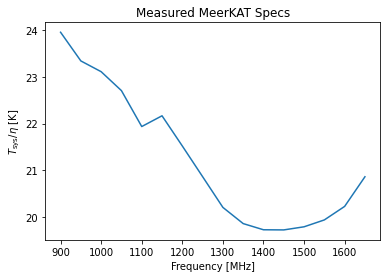

In [1]:
%pylab inline
import numpy as np
from astropy import constants

# Fitted values from recent work.
specs = np.array([[ 900.        ,   23.95144954],
       [ 950.        ,   23.33837709],
       [1000.        ,   23.10850831],
       [1050.        ,   22.70384223],
       [1100.        ,   21.93645197],
       [1150.        ,   22.16621671],
       [1200.        ,   21.52095707],
       [1250.        ,   20.86545365],
       [1300.        ,   20.20854385],
       [1350.        ,   19.86267232],
       [1400.        ,   19.73085187],
       [1450.        ,   19.72759109],
       [1500.        ,   19.79424543],
       [1550.        ,   19.94109374],
       [1600.        ,   20.23018655],
       [1650.        ,   20.86337011]])
plt.plot(specs[:,0],specs[:,1])
plt.title('Measured MeerKAT Specs')
plt.ylabel('$T_\mathrm{sys}/\eta$ [K]')
i=plt.xlabel('Frequency [MHz]')

In [2]:
J = 1e26                                   # Jy to Watts conversion factor
f = specs[:,0]*1e6                         # frequency axis above in Hz
lam = constants.c.value/f                  # corresponding wavelengths in m
f_HI = 1420405751.7667                     # HI rest frequency in Hz
Df = 8.56E8/4096                           # Channel width 4k mode in Hz (Bandwidth divided by channels)     
print('4k mode channel width : {0:f} km/s '.format(Df*constants.c.value/f_HI/1000.))
print(Df)

4k mode channel width : 44.108481 km/s 
208984.375


For reference, the calculations that went into this are:

\begin{align*}
\frac{\Delta\nu}{\Delta V } = \frac{\nu_\mathrm{H I}}{c} 
\end{align*}

$\nu_\mathrm{H I} = 1420405751.7667 \,\mathrm{Hz}$: H I-rest-frequency

$c = 2.99792456\cdot 10^5\, \mathrm{km}\,\mathrm{s}^{-1}$: Speed of light

$\Delta \nu$: Difference between observed and rest frequency

$\Delta V$: Difference in recession velocity (between two adcacent channels)

We obtain (for a bandwidth of 856 MHz and 4096 channels):
\begin{align*}
\Delta V = 44.108\, \mathrm{km}\,\mathrm{s}^{-1}
\end{align*}
\begin{align*}
\Delta\nu = 208984 \,\mathrm{Hz}
\end{align*}

The thermal 5-sigma rms intensity-sensitivity $\sigma_\mathrm{S}$ of a (naturally-weighted) image is found using 
\begin{align*}5\sigma_\mathrm{S} = 5 \frac{2 k_\mathrm{B} T_\mathrm{sys}}{A_\mathrm{eff} [2N(N-1)\Delta \nu_\mathrm{ RF}\tau]^{1/2}}
\end{align*}

$k_\mathrm{B}$: Boltzmann-constant

$T_\mathrm{sys}$: System temperature

$A_\mathrm{eff}$: Effective Aperture (of an antenna)

$N$: Number of antennas

$\Delta \nu_\mathrm{RF}$: Frequency interval (e.g. channel width)

$\tau$: Integration time

The equations are from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php, or https://ui.adsabs.harvard.edu/abs/2013tra..book.....W/abstract, respectively. Any flux density $S$/intensity (and with that the rms in intensity) can be converted to a column-density sensitivity using:

\begin{align*}
 T_\mathrm{B} = \frac{606 \, S}{\vartheta^{2}}
\end{align*}
In this equation, the *HPBW* $\vartheta$ of the synthesized beam is measured in arcseconds, and the flux density $S$ is measured in mJy, to calculate the brightness temperature $T_\mathrm{B}$. We can then calculate the HI-column density $N_\mathrm{H I}$ by integrating over the H I linewidth (measured in $\mathrm{km}\,\mathrm{s}^{-1}$):
\begin{align*}
N_{\rm H\,I} = 1.823 \times 10^{18} \! \int \! T_{\rm B} \, \mathrm{d}V          
 \end{align*}         
Notice that if this is used to calculate the HI column-density sensitivity it is typically wrong to use the channel width in this calculation, unless it is fairly large. Using the channel width one makes the assumption that all HI can be observed within one channel. This is likely correct for 4096 channels, but not any more for 32768 channels. When guessing, the usual assumption is that the HI has a total line width of $16-20\,\mathrm{km}\,\mathrm{s}^{-1}$.


In [9]:
# Parameters to adjust for the observation 
F_tap = 1.6          # The Robust/tapering factor.
theta = 60.          # The synthesized beam HPBW in arcseconds  
N_hi = 1e19          # Target HI column Density in cm^{-2}
SN = 5               # Signal to Noise for detection
hours = 16           # Integration time in hours
N = 58               # Number of Antennas
velocity_width = 20. # in km/s
obs_freq =1.421e9    # Observation frequency in Hz

Use the cell below to compute the flux of a spectral feature:

In [10]:
print('Flux of a column density:')
delta_v = velocity_width 
col_flux = N_hi*theta**2/(1.823e18*606.*delta_v)
string1 = "N_hi = {0:2.4g} at {1} arc-seconds  with a velocity width of {2:2.4g} km/s, has a flux of {3:2.4g} mJy. "
string2 = "To detect this at a {1:.0f}-sigma level (taper factor of {2:2.2g}),\nwe would need an image with a natural rms of {3:2.4g} mJy"
print(string1.format(N_hi,theta,velocity_width,col_flux))
print(string2.format(N_hi,SN,F_tap,col_flux/(F_tap*SN)))

Flux of a column density:
N_hi = 1e+19 at 60.0 arc-seconds  with a velocity width of 20 km/s, has a flux of 1.629 mJy. 
To detect this at a 5-sigma level (taper factor of 1.6),
we would need an image with a natural rms of 0.2037 mJy


Use the cell below to compute the image rms (single-channel), and resulting detection level:

In [8]:
sigma = SN 
D = 13.5             # Meters
f_HI = 1420405751.7667 # Hz
NPol = 2
A = np.pi * (D/2)**2
Tsys_eta = specs[:,1]
bw = f_HI/constants.c.value*velocity_width*1000.    
tau = 3600 * hours
Tsys_per_eta = Tsys_eta[np.argmin(np.abs(f - obs_freq))]
print ("T_sys/eta at %3.0f MHz is %2.1fK"%(obs_freq/1e6,Tsys_per_eta) )
print("Flux/rms calculated from the observing time: ")
noise = 2 * constants.k_B.value * Tsys_per_eta / (A * np.sqrt(N * (N-1) * bw * tau)) * J / np.sqrt(NPol) 
#rms_L =  2 * k * Tsys_eta_L / (A * sqrt(N * (N-1) * bw_L * tau)) * J / sqrt(NPol)
print("Natural rms noise after {:.1f}h on-source is {:2.4g} mJy".format(hours, noise*1e3)) 
print("With a taper factor of {:.1f}, this becomes {:2.4g} mJy".format(F_tap, F_tap*noise*1e3)) 
print("The {:.0f}-sigma detection level is then {:2.4g} mJy".format(sigma, sigma*F_tap*noise*1e3))

T_sys/eta at 1421 MHz is 19.7K
Flux/rms calculated from the observing time: 
Natural rms noise after 16.0h on-source is 0.04372 mJy
With a taper factor of 1.6, this becomes 0.06996 mJy
The 5-sigma detection level is then 0.3498 mJy
